Import modules

In [1]:
import numpy as np
from tensorflow import keras as ks
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from skimage.io import imread, imsave
from matplotlib import pyplot as plt
from matplotlib import figure
from matplotlib.ticker import MaxNLocator
from styleTransfer import generateImageFromGramMatrix, generateImageFromStyle
import os
import asyncio

%matplotlib inline
%load_ext autoreload
%autoreload 2


some constants

In [46]:
TRAIN = 'train2'
classes = ['300.9', '600.3', '600.9']
imgDir = 'train2'
TRAINING_SIZE = 1800
BATCH_SIZE = 20
IMAGE_SIZE = (448, 448)


Create sliding window of the 4 original dataset

two helper functions

In [5]:
"""
read all images from a folder
"""

def load_images_from_folder(folder):
	images = []
	for filename in os.listdir(folder):
		img = cv2.imread(os.path.join(folder,filename))
		if img is not None:
			images.append(img)
	return images


"""
write all possible sliding windows to disk
"""

def sliding_window(image, stepSize, windowSize, classPath):
	# slide a window across the image
	counterImages = 0
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			currWindow = image[y: y + windowSize[1], x: x + windowSize[0]]
			if currWindow.shape != (448, 448, 3):
				continue
			currImagePath = os.path.join(classPath, str(counterImages)) + '.png'
			cv2.imwrite(currImagePath, currWindow)
			counterImages += 1


start the sliding window generation process

In [0]:

images = load_images_from_folder('orig')

counter = 0
for image in images:
	classPath = os.path.join(TRAIN, classes[counter])
	if not os.path.exists(classPath):
		os.mkdir(classPath)
	sliding_window(image, 3, (448, 448), classPath)
	counter+=1



Read generated sliding window and do data augmentation 
by randomly seleft and random flips

Found 230517 images belonging to 3 classes.
{'300.9': 0, '600.3': 1, '600.9': 2}


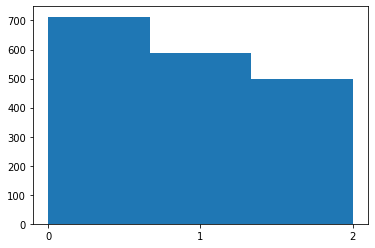

In [47]:


data = None
labels = None
aug = ImageDataGenerator(
		horizontal_flip=True,
		vertical_flip=True,
		fill_mode="nearest")


augmentation = aug.flow_from_directory(imgDir,classes=classes, batch_size = TRAINING_SIZE, target_size=IMAGE_SIZE,shuffle=True, seed=20, class_mode="sparse")
print(augmentation.class_indices)
for x, y in augmentation:
	data = x
	labels = y
	break

data = data.astype(np.float32) / 255.0
fig = plt.figure()
fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.hist(labels, len(classes))
plt.show()


Draw figure of original pics

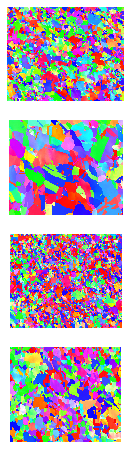

In [48]:
fig = plt.figure(figsize=(16, 8))
counter = 1
for subdir, dirs, files in os.walk('orig'):
	for file in files:
		origImg = cv2.imread(os.path.join(subdir, file))
		fig.add_subplot(4, 1, counter)
		plt.axis('off')
		plt.imshow(origImg)
		counter += 1
plt.savefig('original.png', transparent=True)
plt.show()


Figure X: The four original dataset. 

Draw figure for augmented pics

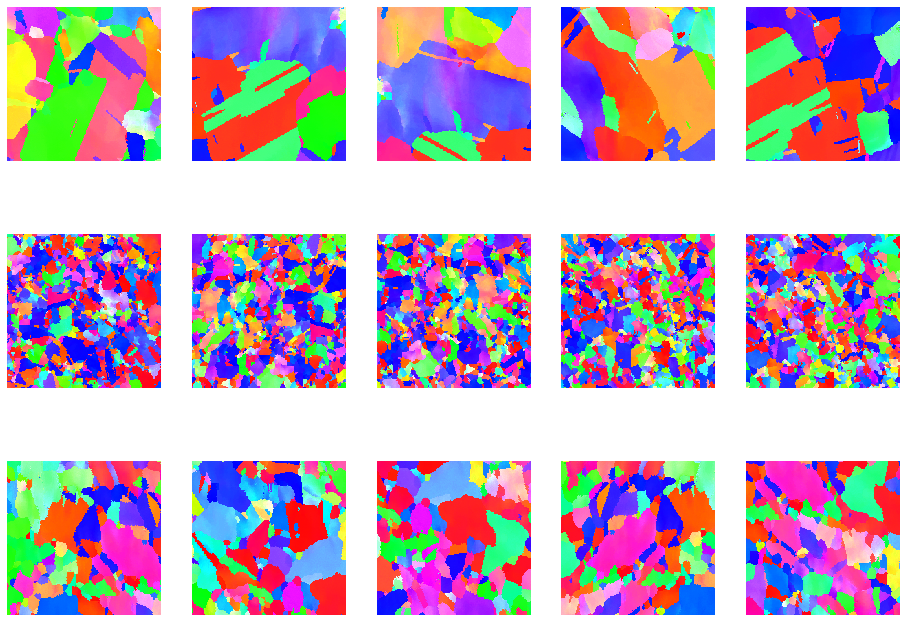

In [49]:
fig = plt.figure(figsize=(16, 16))

counter = 1
for i in range(len(classes)):
		idx = np.random.choice(np.where(labels == i)[0], 5)
		for j in idx:
			   fig.add_subplot(4, 5, counter)
			   plt.axis('off')
			   plt.imshow(data[j])
			   counter += 1
plt.savefig('sample.png', transparent=True)
plt.show()


Figure X: Some sample of augmented dataset

extract features

This function calculate the gram matrix

In [50]:
def gram_matrix_batch(x):
    features = K.reshape(x, shape=(K.shape(x)[0], x.shape[1] * x.shape[2], x.shape[3]))
    features_T = K.permute_dimensions(features, (0, 2, 1))
    gram = K.batch_dot(features_T, features)
    gram = K.batch_flatten(gram)
    return gram

Construct the VGG 16 network

In [51]:
input_tensor = K.placeholder((None, ) + data.shape[1:])
network = VGG16(weights="imagenet", include_top=False, input_tensor=input_tensor)
#features = network.predict(data)

Get functors for the gram matrix for each layers for a whole batch

In [52]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
layers = dict([(layer.name, layer.output) for layer in network.layers])
all_grams = []
for layer_name in feature_layers:
    style_features = layers[layer_name]
    gram = gram_matrix_batch(style_features)
    all_grams.append(gram)

functor = K.function(input_tensor, all_grams)


Get the gram matrix value

In [53]:
def get_gram_batch(data):
    n_split = TRAINING_SIZE / BATCH_SIZE
    spliltted = np.array_split(data, n_split)
    results = []
    for batch in spliltted:
        batch_result = functor(batch)
        results.append(np.concatenate(batch_result, axis=1))
    features = np.concatenate(results, axis=0)
    return features
    

In [54]:
features = get_gram_batch(data)
features.shape

(1800, 610304)

Helper function to evaluate different dimensions of PCA with different type of SVM

In [55]:
async def evaluateSVM_PCA(dimension, data, labels, SVM_type):
	pca = PCA(n_components=dimension)
	pcaFeatures = pca.fit_transform(data)
	X_train, X_test, y_train, y_test = train_test_split(pcaFeatures, labels, shuffle=False, test_size = 0.2)
	if SVM_type == 'linear':
		model = svm.LinearSVC(max_iter=99999)
		model.fit(X_train, y_train)
		score = model.score(X_test, y_test)
	return score


Evaluate and plot accuracies of different models

In [56]:
accuracies = dict()
accuracies['LinearSVM'] = await asyncio.gather(*[evaluateSVM_PCA(i, features, labels, 'linear') for i in range(2, 20)])

c:\program files\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

plot accuracies with different SVM and PCA components

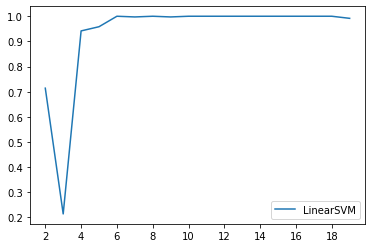

In [57]:
fig = plt.figure()
fig.add_subplot()
x = range(2,20)
plt.plot(x, accuracies['LinearSVM'])
fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(['LinearSVM'])
plt.savefig('acc_vs_npc.png')
plt.show()

Figure X: Accuracy vs number of principal comnponents. 
Tested on three SVM models. 
A normal SVM model
with no kernel. A SVM model with 3 degree polynomial kernel 
and a SVM with radial basis kernel

Train the classifer with dimension=10 and evaluate the result

In [60]:
pca = PCA(n_components=6)
pcaFeatures = pca.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(pcaFeatures, labels, shuffle=False, test_size=0.2)


draw the confusion matrix

c:\program files\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


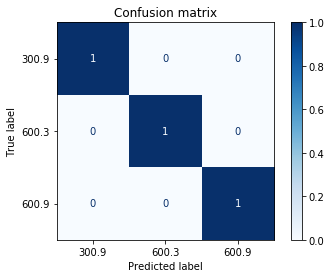

In [61]:
model = svm.LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
disp = plot_confusion_matrix(model, X_test, y_test, display_labels=classes, normalize='true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion matrix')
plt.savefig('confmat.png')
plt.show()

Figure X: Confusion matrix of the optimal model. 

In [ ]:
Draw the scatter plot (PCA reduced domain) visualize feature using first two components of PCA

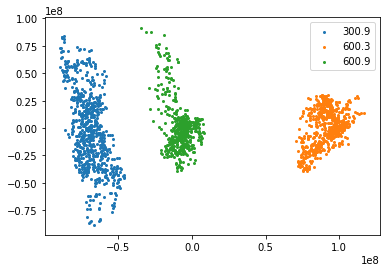

In [62]:
fig = plt.figure()
fig.add_subplot()

counter = 1
for i in range(4):
		idx = np.where(labels == i)
		plt.scatter(pcaFeatures[idx, 0], pcaFeatures[idx, 1], s=4)

plt.legend(classes)
plt.savefig('pca.png')
plt.show()


Figure X: Plot of first two princial components of the dataset 

Put new image in the plot

In [72]:
def projectImage(newImg, pca, pcaFeatures):

    newFeatures = get_gram_batch(newImg[np.newaxis, :, :])
    newPCAFeatures = pca.transform(newFeatures)

    fig = plt.figure()
    fig.add_subplot()

    counter = 1
    for i in range(4):
        idx = np.where(labels == i)
        plt.scatter(pcaFeatures[idx, 0], pcaFeatures[idx, 1], s=4)

    plt.scatter(newPCAFeatures[0, 0], pcaFeatures[0, 1], s=400, marker='x')
    plt.legend([*classes, 'New Data'], loc='lower right')
    plt.show()

Generate new sample from image 600.9 (label=2)

In [113]:
idx = np.random.choice(np.where(labels == 2)[0], 1)
styleImg = data[idx]
CONTENT_WEIGHT = 0
TOTAL_VARIATION_WEIGHT = 0.0
STYLE_WEIGHT = 1.0

generated = generateImageFromStyle(H=IMAGE_SIZE[0], W=IMAGE_SIZE[1], C=3, S_weight=STYLE_WEIGHT, V_weight=TOTAL_VARIATION_WEIGHT, style_image=styleImg, iters=20)

Start of iteration 0
Current loss value: 1317.0919
Iteration 0 completed in 4s
Start of iteration 1
Current loss value: 919.49
Iteration 1 completed in 3s
Start of iteration 2
Current loss value: 681.2264
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 522.23444
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 438.1673
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 392.20154
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 363.1632
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 344.9392
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 334.06146
Iteration 8 completed in 3s
Start of iteration 9
Current loss value: 326.61932
Iteration 9 completed in 3s
Start of iteration 10
Current loss value: 321.56473
Iteration 10 completed in 3s
Start of iteration 11
Current loss value: 318.0796
Iteration 11 completed in 3s
Start of iteration 12
Current loss value: 315.39212
Iter

Show the generated image and project it to the reduced domain

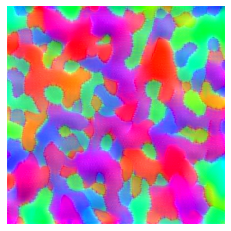

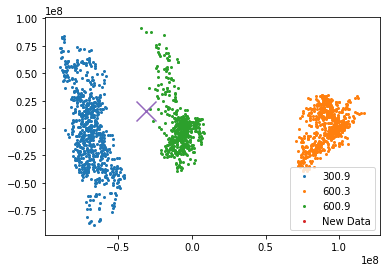

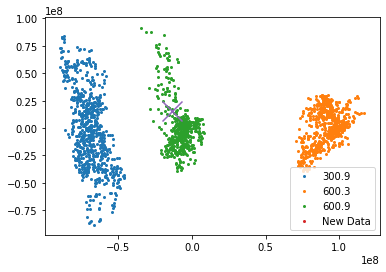

In [114]:
fig = plt.figure()
plt.axis('off')
plt.imshow(generated)
imsave('generated.png', generated)

projectImage(generated.astype(np.float32) / 255.0, pca, pcaFeatures)
projectImage(styleImg[0, :, :, :], pca, pcaFeatures)

In [ ]:
Try to figure out the validity of the generated image. 

In [111]:
def correcoeHist(imgA, imgB):
    histA_R = cv2.calcHist(imgA, [0],None, [256], [0,256])
    histA_G = cv2.calcHist(imgA, [1],None, [256], [0,256])
    histA_B = cv2.calcHist(imgA, [2],None, [256], [0,256])

    histB_R = cv2.calcHist(imgB, [0],None, [256], [0,256])
    histB_G = cv2.calcHist(imgB, [1],None, [256], [0,256])
    histB_B = cv2.calcHist(imgB, [2],None, [256], [0,256])
    
    histA = np.concatenate([histA_R, histA_G, histA_B], axis=0)
    histB = np.concatenate([histB_R, histB_G, histB_B], axis=0)
    return cv2.compareHist(histA, histB, cv2.HISTCMP_CORREL)
    
    # histA = cv2.calcHist([imgA], [0, 1, 2], None, [256] * 3, [0,256] * 3)
    # histB = cv2.calcHist([imgB], [0, 1, 2], None, [256] * 3, [0,256] * 3)
    
    return [cv2.compareHist(histA_R, histB_R, cv2.HISTCMP_CORREL), cv2.compareHist(histA_G, histB_G, cv2.HISTCMP_CORREL), cv2.compareHist(histA_B, histB_B, cv2.HISTCMP_CORREL)]

In [115]:
correcoeHist(styleImg[0, :, :, :], generated.astype(np.float32))

0.4386521307181028

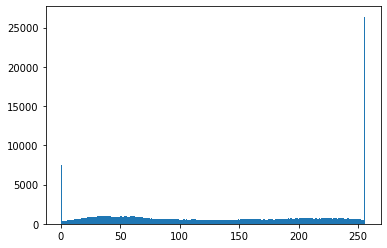

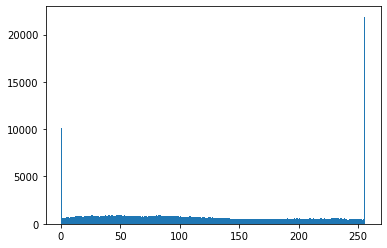

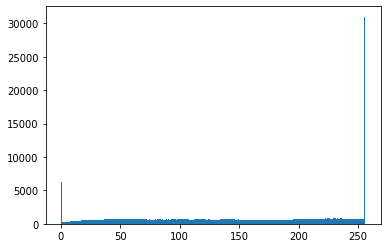

In [25]:
GENERATED_IMG = 'generated300.3_0VAR.png'
ORIGINAL_IMG = '600.3_.png'
img = imread(GENERATED_IMG)
img2 = imread(ORIGINAL_IMG)

plt.hist(img[:, :, 0].ravel(),256,[0,256])
plt.show()
plt.hist(img[:, :, 1].ravel(),256,[0,256])
plt.show()
plt.hist(img[:, :, 2].ravel(),256,[0,256])
plt.show()


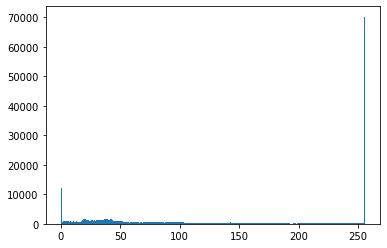

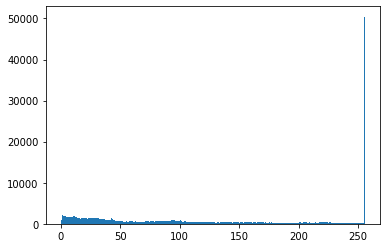

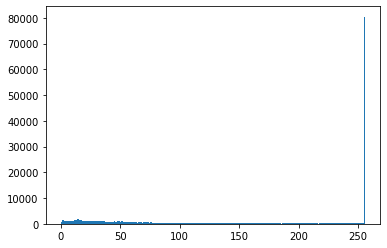

In [26]:
plt.hist(img2[:, :, 0].ravel(),256,[0,256])
plt.show()
plt.hist(img2[:, :, 1].ravel(),256,[0,256])
plt.show()
plt.hist(img2[:, :, 2].ravel(),256,[0,256])
plt.show()

Figure X: Put new data in the scatter plot

Try to generate in-between data

In [68]:
def generateInBetween(imgA, imgB):
    STYLE_WEIGHT = 1.0
    VAR_WEIGHT = 0.0  
    featuresAB_full = get_gram_batch(np.stack([imgA, imgB], axis=0))
    featuresAB = pca.transform(featuresAB_full)
    midpoint = np.sum(featuresAB, axis=0) / 2.0
    gram_mat_mid = pca.inverse_transform(midpoint)
    generated = generateImageFromGramMatrix(gram_mat_mid, H=IMAGE_SIZE[0], W=IMAGE_SIZE[1], C=3, S_weight=STYLE_WEIGHT, V_weight=VAR_WEIGHT, iters=20)
    return generated

generate in-between sampels from 300.9, 600.9

In [74]:
idxA = np.random.choice(np.where(labels == 0)[0], 1)
idxB = np.random.choice(np.where(labels == 2)[0], 1)
imgA = data[idxA]
imgB = data[idxB]
generated = generateInBetween(imgA[0, :, :, :], imgB[0, :, :, :])


Start of iteration 0
Current loss value: 1325.8846
Iteration 0 completed in 3s
Start of iteration 1
Current loss value: 876.1854
Iteration 1 completed in 2s
Start of iteration 2
Current loss value: 537.2057
Iteration 2 completed in 2s
Start of iteration 3
Current loss value: 381.92975
Iteration 3 completed in 2s
Start of iteration 4
Current loss value: 304.16406
Iteration 4 completed in 2s
Start of iteration 5
Current loss value: 261.5028
Iteration 5 completed in 2s
Start of iteration 6
Current loss value: 234.84897
Iteration 6 completed in 2s
Start of iteration 7
Current loss value: 217.91248
Iteration 7 completed in 2s
Start of iteration 8
Current loss value: 207.4413
Iteration 8 completed in 2s
Start of iteration 9
Current loss value: 200.69937
Iteration 9 completed in 2s
Start of iteration 10
Current loss value: 195.61966
Iteration 10 completed in 2s
Start of iteration 11
Current loss value: 192.1951
Iteration 11 completed in 2s
Start of iteration 12
Current loss value: 189.68193
I

Show the in-between data in plot

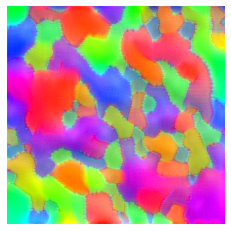

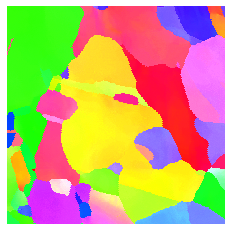

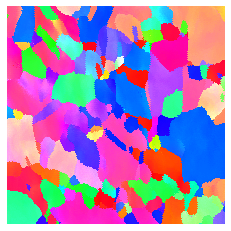

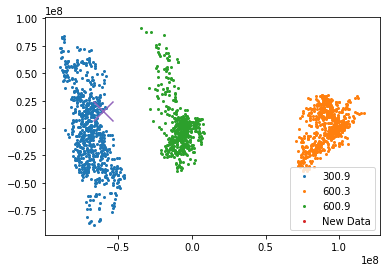

In [78]:
fig = plt.figure()
plt.axis('off')
plt.imshow(generated)
fig = plt.figure()
plt.axis('off')
plt.imshow(imgA[0, :, :, :])
fig = plt.figure()
plt.axis('off')
plt.imshow(imgB[0, :, :, :])

imsave('in-between.png', generated)
projectImage(generated.astype(np.float32) / 255.0, pca, pcaFeatures)

Project 2 images used to generate in-between data to the plot

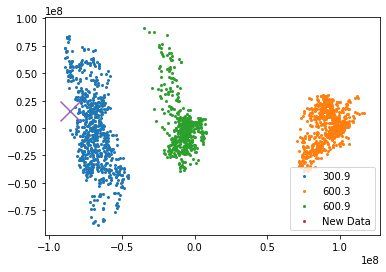

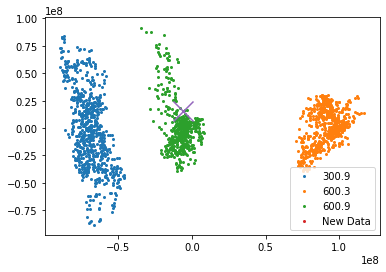

In [77]:

projectImage(imgA[0, :, :, :], pca, pcaFeatures)
projectImage(imgB[0, :, :, :], pca, pcaFeatures)

In [37]:
K.clear_session()